# Game of Life


## Setup

In [ ]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

Downloaded utils.py


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def make_table(rule):
    """Makes the CA table for a given rule.

    rule: integer 0-255

    returns: NumPy array of uint8
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table


def print_table(table):
    """Prints the rule table in LaTeX format."""
    print('\\beforefig')
    print('\\centerline{')
    print('\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}')
    print('\\hline')

    res = ['prev'] + ['{0:03b}'.format(i) for i in range(8)]
    print(' & '.join(res) + ' \\\\ \n\\hline')

    res = ['next'] + [str(x) for x in table]
    print(' &   '.join(res) + ' \\\\ \n\\hline')

    print('\\end{tabular}}')


class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Blues', alpha=0.7)

        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])


def draw_ca(rule, n=32):
    """Makes and draw a 1D CA with a given rule.

    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    ca.draw()

In [ ]:
from time import sleep
from IPython.display import clear_output
from utils import underride


class Cell2D:
    """Parent class for 2-D cellular automata."""

    def __init__(self, n, m=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1):
        """Runs the given number of steps."""
        for i in range(iters):
            self.step()

    def draw(self, **options):
        """Draws the array.
        """
        draw_array(self.array, **options)

    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step

        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass


def draw_array(array, **options):
    """Draws the cells."""
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

In [ ]:
from utils import decorate, savefig

# make a directory for figures
!mkdir -p figs

# Implementing Game of Life

As an example, let's start with an array of random cells:

[`np.random.randint`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) is one of the function for doing random sampling in numpy.  It returns an array of specified shape and fills it with random integers from low (inclusive) to high (exclusive), i.e. in the interval [low, high).

In [ ]:
a = np.random.randint(2, size=(10, 10), dtype=np.uint8)
print(a)

[[0 1 0 0 0 1 0 1 0 0]
 [1 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 1 1 1 0 1 1]
 [1 0 1 1 0 0 1 0 1 1]
 [1 0 0 1 1 1 1 0 0 1]
 [1 0 1 0 0 1 0 0 1 1]
 [1 0 0 1 0 0 0 0 1 1]
 [0 1 1 1 1 0 1 0 1 1]]


In [ ]:
def plot_ca(array):
    plt.imshow(array, cmap='Greens', interpolation='none')
    rows, cols = array.shape
    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, cols, 1))
    ax.set_yticks(np.arange(0, rows, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, cols, 1))
    ax.set_yticklabels(np.arange(0, rows, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)

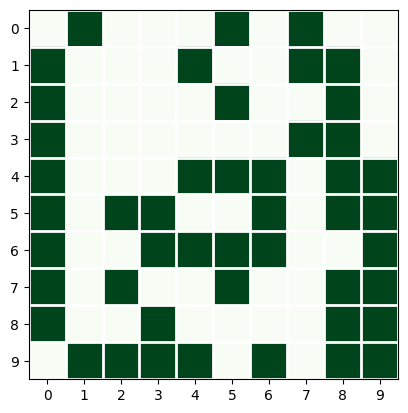

In [ ]:
plot_ca(a)

The following is a straightforward translation of the GoL rules using `for` loops and array slicing.

[`np.zeros_like`](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html) returns an array of zeros with the same shape and type as a given array.

***A simple version that not considering the boundary of the array:***

In [ ]:
b = np.zeros_like(a)
rows, cols = a.shape

for i in range(1, rows-1):
    for j in range(1, cols-1):
        state = a[i, j]
        neighbors = a[i-1:i+2, j-1:j+2]
        k = np.sum(neighbors) - state  # surrounding 8 neighbors
        if state: # if state==1 (if cell is alive)
            if k==2 or k==3:
                b[i, j] = 1 # it stays alive if it has 2 or 3 neighbors
        else: # if a cell is dead
            if k == 3:
                b[i, j] = 1 #it stays dead unless it has exactly 3 neighbors

print(b)

[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 0 1 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


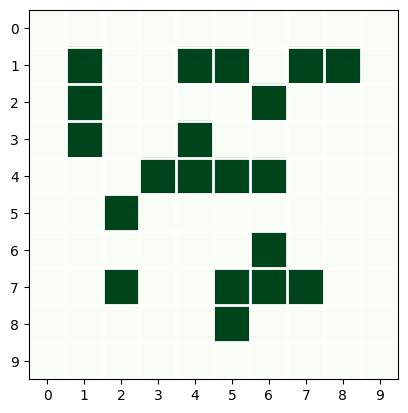

In [ ]:
plot_ca(b)

**Here's a smaller, faster version using cross correlation.**

`correlate2d` **multiplies the kernel and the array** to select a neighborhood, then **adds up the result**. This kernel selects the **8 neighbors** that surround the center cell.

With `mode='same'`, the result has
the same size as a.

In [ ]:
from scipy.signal import correlate2d

# kernel selects the 8 neighbors that surround the center cell.
kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

c = correlate2d(a, kernel, mode='same')

In [ ]:
c

array([[2, 1, 1, 1, 2, 1, 3, 2, 3, 1],
       [2, 3, 1, 1, 2, 3, 4, 3, 3, 2],
       [2, 3, 0, 1, 2, 1, 3, 5, 4, 3],
       [2, 3, 0, 1, 3, 4, 4, 4, 4, 4],
       [2, 4, 2, 3, 2, 3, 3, 6, 5, 4],
       [2, 4, 2, 4, 6, 7, 4, 5, 4, 4],
       [2, 5, 4, 4, 4, 4, 3, 4, 5, 4],
       [2, 4, 2, 4, 5, 3, 3, 3, 4, 4],
       [2, 5, 5, 4, 4, 3, 2, 4, 5, 5],
       [2, 2, 3, 3, 2, 2, 0, 3, 3, 3]])

In [ ]:
def annotate_ca_text(array, annotations):
    """
    array: orignal array to be annotated
    annotations: array of same size, contains the sum of neighbours
    """
    plt.imshow(array, cmap='Greens', interpolation='none')
    rows, cols = array.shape
    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, cols, 1))
    ax.set_yticks(np.arange(0, rows, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, cols, 1))
    ax.set_yticklabels(np.arange(0, rows, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)

    for i in range(annotations.shape[0]):
        for j in range(annotations.shape[1]):
            ax.text(j, i, str(annotations[i, j]), ha='center', va='center', fontsize=10)

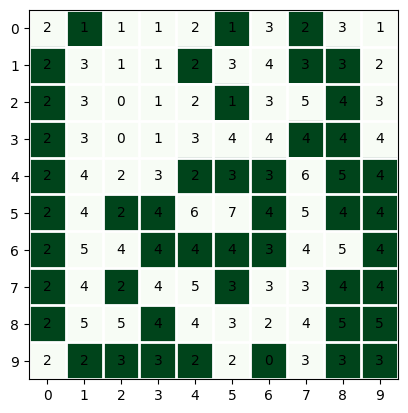

In [ ]:
# annoatate the neighbour numbers over the original array
annotate_ca_text(a,c)

In [ ]:
b = np.zeros_like(a)
b = (c==3) | (c==2) & a  # (c==3) | (c==2) & a==1
                         # justify True or False returning 1 or 0.
b = b.astype(np.uint8)
print(b)

[[0 0 0 0 0 0 1 1 1 0]
 [1 1 0 0 1 1 0 1 1 0]
 [1 1 0 0 0 0 1 0 0 1]
 [1 1 0 0 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 1 1 1 0 0 1 1 1]]


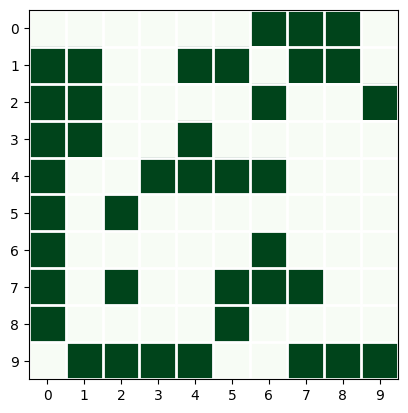

In [ ]:
plot_ca(b)

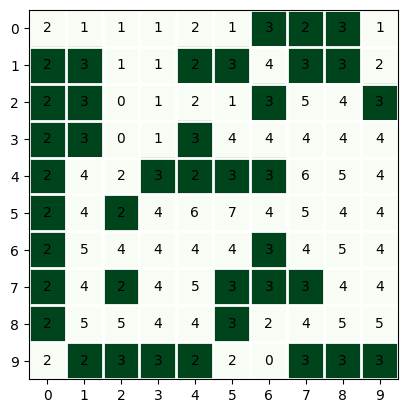

In [ ]:
# check that all alive cells have 2 or 3 neighbours
# and no dead cells have 3 neighbours

annotate_ca_text(b,c)

**Using a kernel that gives a weight of 10 to the center cell, we can simplify the logic a little.**

In [ ]:
kernel = np.array([[1, 1, 1],
                   [1,10, 1],
                   [1, 1, 1]])

c = correlate2d(a, kernel, mode='same')

In [ ]:
c

array([[ 2, 11,  1,  1,  2, 11,  3, 12,  3,  1],
       [12,  3,  1,  1, 12,  3,  4, 13, 13,  2],
       [12,  3,  0,  1,  2, 11,  3,  5, 14,  3],
       [12,  3,  0,  1,  3,  4,  4, 14, 14,  4],
       [12,  4,  2,  3, 12, 13, 13,  6, 15, 14],
       [12,  4, 12, 14,  6,  7, 14,  5, 14, 14],
       [12,  5,  4, 14, 14, 14, 13,  4,  5, 14],
       [12,  4, 12,  4,  5, 13,  3,  3, 14, 14],
       [12,  5,  5, 14,  4,  3,  2,  4, 15, 15],
       [ 2, 12, 13, 13, 12,  2, 10,  3, 13, 13]])

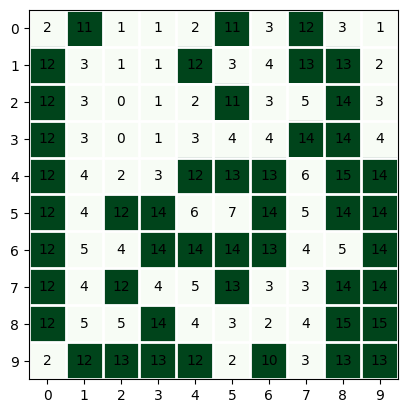

In [ ]:
annotate_ca_text(a,c)

In [ ]:
# center cell was dead (i.e. 0), has three neighbors --> back to live, c == 3
# center cell was alive (i.e. 10), has two neighbors --> stay alive, c == 12
# center cell was alive (i.e. 10), has three neighbors --> stay alive, c == 13
b = np.zeros_like(a)

b = (c==3) | (c==12) | (c==13)
b = b.astype(np.uint8)
print(b)

[[0 0 0 0 0 0 1 1 1 0]
 [1 1 0 0 1 1 0 1 1 0]
 [1 1 0 0 0 0 1 0 0 1]
 [1 1 0 0 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 1 1 1 0 0 1 1 1]]


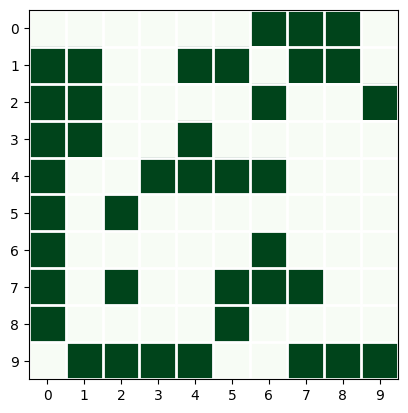

In [ ]:
plot_ca(b)

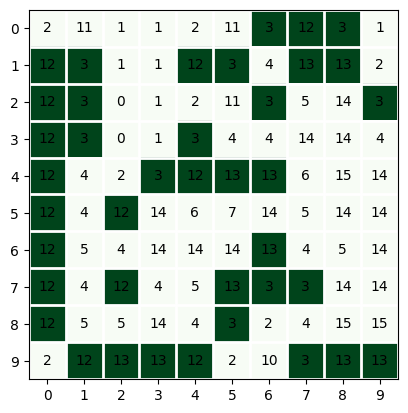

In [ ]:
annotate_ca_text(b,c)

More importantly, the second version of the kernel makes it possible to use a look up table to get the next state, which is faster and even more concise.

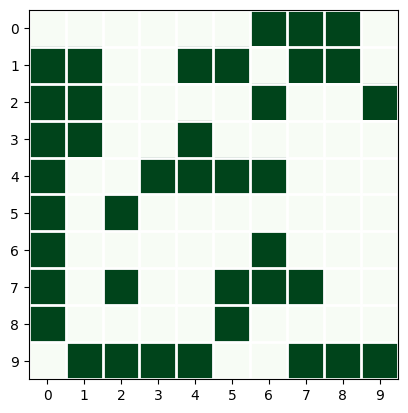

In [ ]:
table = np.zeros(20, dtype=np.uint8)
table[[3, 12, 13]] = 1
c = correlate2d(a, kernel, mode='same')
b = np.zeros_like(a)

b = table[c] # use c as index into table
plot_ca(b)

In [ ]:
table

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

# Game of Life entities



In [ ]:
from scipy.signal import correlate2d

class Life(Cell2D): # inherit from class Cell2D
    """Implementation of Conway's Game of Life."""
    kernel = np.array([[1, 1, 1],
                       [1,10, 1],
                       [1, 1, 1]])

    table = np.zeros(20, dtype=np.uint8)
    table[[3, 12, 13]] = 1

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array = self.table[c]

The following function creates a `Life` object and sets the initial condition using strings of `0` and `1` characters.

In [ ]:
def make_life(n, m, row, col, *strings):
    """Makes a Life object.

    n, m: rows and columns of the Life array
    row, col: upper left coordinate of the cells to be added
    strings: list of strings of '0' and '1'
    """
    life = Life(n, m) # initialize 3x4 array with all zero values
    life.add_cells(row, col, *strings) # add values to the initialized array based on the given strings.
    return life

## Beehive
A beehive is a stable entity, also called a "still life"

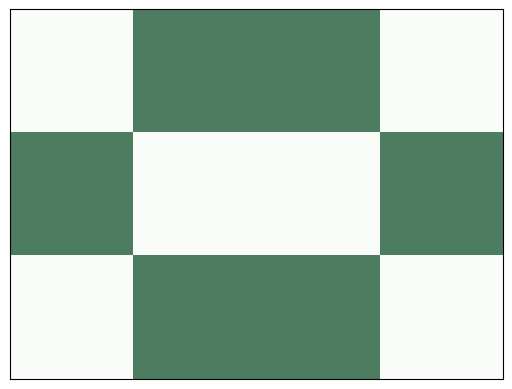

In [ ]:
# beehive

life = make_life(3, 4, 0, 0, '0110', '1001', '0110')
life.draw()


Here's what it looks like after one step:

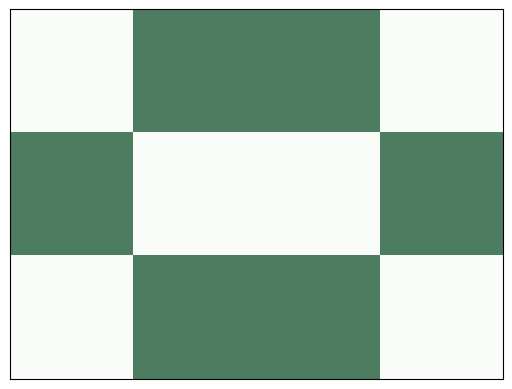

In [ ]:
life.step()
life.draw()

### Some illustration:

How the `correlate2d` works?

Slide the kernel (window) over the given array; if the `mode='same'`, padding zero surrounding the array to make the output be in the same size.


In [ ]:
# check class Cell2D

life.array # inherit from class Cell2D

array([[0, 1, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 0]], dtype=uint8)

In [ ]:
life.kernel

array([[ 1,  1,  1],
       [ 1, 10,  1],
       [ 1,  1,  1]])

In [ ]:
# mode = 'same', paddinng zero surrounding the array to make the output be in same size
# slide the kernel over array: element-wise multiplication and then sum up.
# (same as the correlation we saw in 1D-CA last week)

correlate2d(life.array, life.kernel, mode='same')

# the results are regarded as the index number extracing item from life.table

array([[ 2, 12, 12,  2],
       [12,  5,  5, 12],
       [ 2, 12, 12,  2]])

In [ ]:
# rules to update the state values
life.table

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [ ]:
life.table[correlate2d(life.array, life.kernel, mode='same')]

array([[0, 1, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 0]], dtype=uint8)

## Toad

A toad is an oscillator with period 2.  Here's are its two configurations:

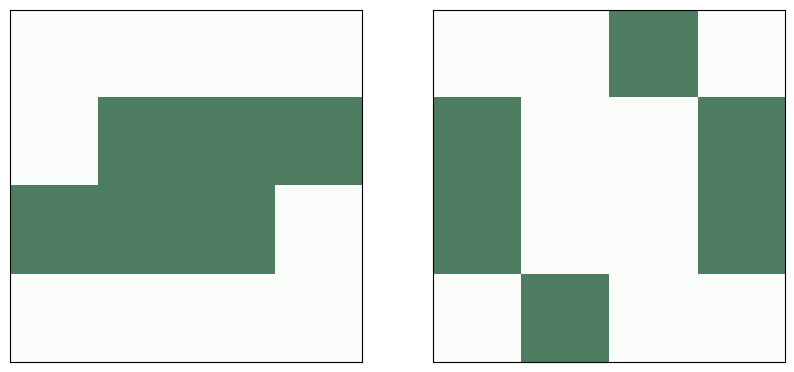

In [ ]:
# toad
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
life = make_life(4, 4, 1, 0, '0111', '1110')
life.draw()

plt.subplot(1, 2, 2)
life.step()
life.draw()


Here's what the toad looks like as an animation.

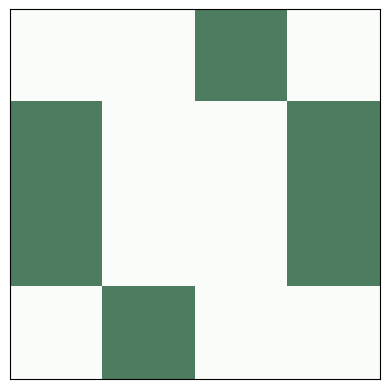

In [ ]:
life = make_life(4, 4, 1, 0, '0111', '1110')
life.animate(10, 0.5) # draw 10 frames

## Glider
A glider is a spaceship that translates one unit down and to the right with period 4.

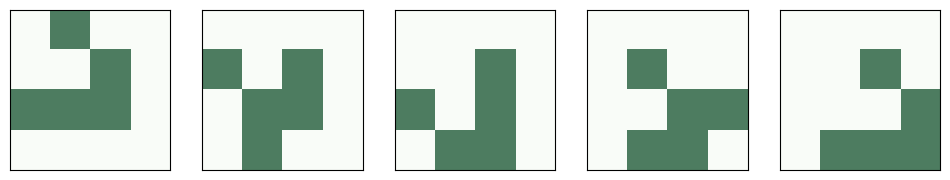

In [ ]:
# glider
plt.figure(figsize=(12, 4))

glider = ['010', '001', '111']
life = make_life(4, 4, 0, 0, *glider)

for i in range(1, 6):
    plt.subplot(1, 5, i)
    life.draw()
    life.step()


Here's an animation showing glider movement.

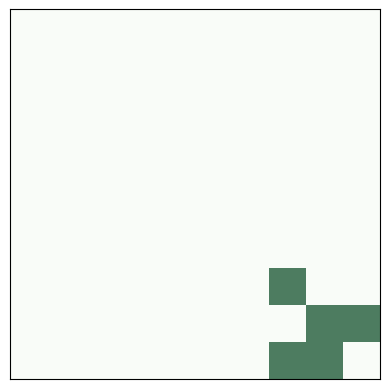

In [ ]:
life = make_life(10, 10, 0, 0, '010', '001', '111')
life.animate(frames=28, interval=0.2)

# Methuselas

Most initial conditions run for a short time and reach a steady state.  But some initial conditional run for a surprisingly long time; they are called [Methuselahs](https://en.wikipedia.org/wiki/Methuselah_(cellular_automaton)).

The r-pentomino starts with only five live cells, but it runs for 1103 steps before stabilizing.

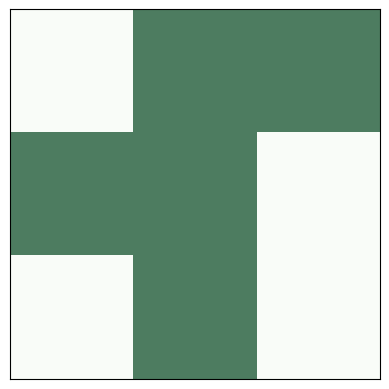

In [ ]:
# r pentomino
rpent = ['011', '110', '010']
life = make_life(3, 3, 0, 0, *rpent)
life.draw()

Here are the start and finish configurations.

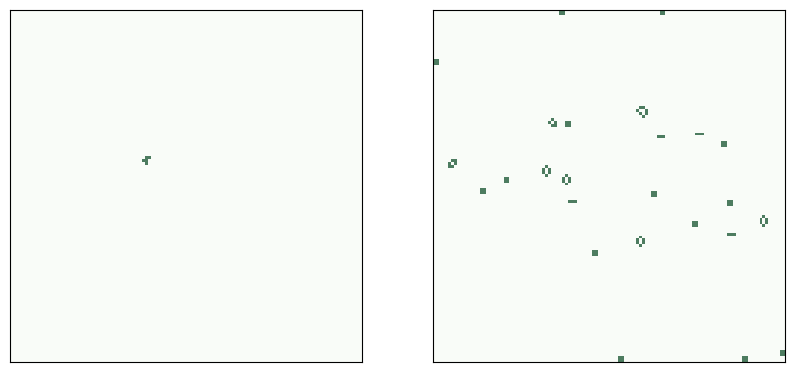

In [ ]:
# r pentomino
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
life = make_life(120, 120, 50, 45, *rpent)
life.draw()

for i in range(1103):
    life.step()

plt.subplot(1, 2, 2)
life.draw()

And here's the animation that shows the steps.

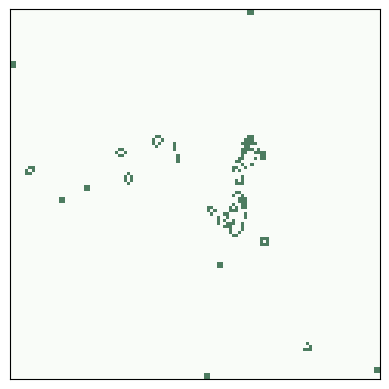

In [ ]:
life = make_life(120, 120, 50, 45, *rpent)
life.animate(frames=1200)

# Conway's conjecture

Most initial conditions run for a short time and reach a steady state.  Some, like the r-pentomino, run for a long time before they reach steady state.  Another example is [rabbits](https://web.archive.org/web/20081221152607/http://www.argentum.freeserve.co.uk/lex_r.htm#rabbits), which starts with only nine cells and runs 17331 steps before reaching steady state.

Patterns that take a long time to reach steady state are called [Methuselahs](https://en.wikipedia.org/wiki/Methuselah_(cellular_automaton))

Patterns like these prompted Conway's conjecture, which asks whether there are any initial conditions where the number of live cells is unbounded.

Gosper's glider gun was the first entity to be discovered that produces an unbounded number of live cells, which refutes Conway's conjecture.

In [ ]:
glider_gun = [
    '000000000000000000000000100000000000',
    '000000000000000000000010100000000000',
    '000000000000110000001100000000000011',
    '000000000001000100001100000000000011',
    '110000000010000010001100000000000000',
    '110000000010001011000010100000000000',
    '000000000010000010000000100000000000',
    '000000000001000100000000000000000000',
    '000000000000110000000000000000000000'
]

Here's the initial configuration:

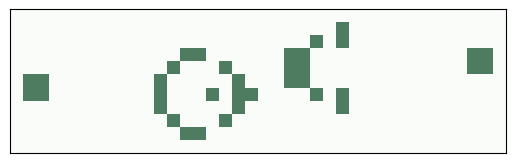

In [ ]:
life = make_life(11, 38, 1, 1, *glider_gun)
life.draw()

And here's what it looks like running:

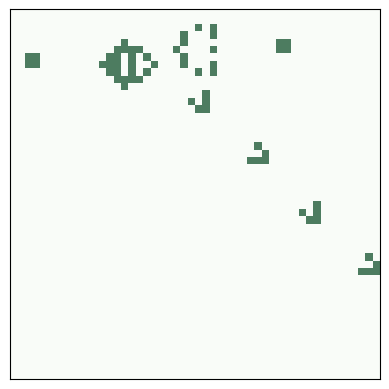

In [ ]:
life = make_life(50, 50, 2, 2, *glider_gun)
life.animate(frames=300)

Another way to refute Conway's conjecture is a [puffer train](https://en.wikipedia.org/wiki/Puffer_train).

# Physical Modelling

## Diffusion

Before we get to a Reaction-Diffusion model, we'll start with simple diffusion.

**The kernel computes the difference between each cell and the sum of its neighbors.**

**At each time step, we compute this difference, multiply by a constant, and add it back in to the array.**

If the concentration of the center cell exceeds the neighborhood average, the chemical flows from the center to the neighbors. If the concentration of the center cell is lower, the chemical flows the other way.

In [ ]:
from scipy.signal import correlate2d

class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, r=0.1):
        """Initializes the attributes.

        n: number of rows
        r: diffusion rate constant
        """
        self.r = r
        self.array = np.zeros((n, n), float)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Reds')

Here's a simple example starting with an "island" of material in the middle.

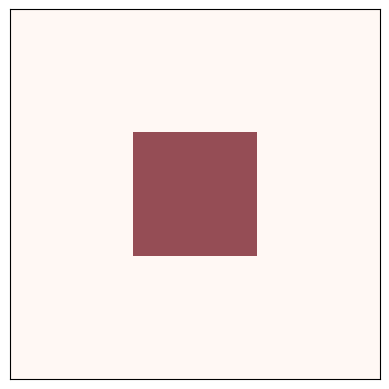

In [ ]:
diff = Diffusion(n=9, r=0.1) # initialize a 9x9 array
diff.add_cells(3, 3, '111', '111', '111') # initial 0 everywhere except for an “island” in the middle
diff.draw()

In [ ]:
diff.array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
diff.step()
diff.array

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0.1, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.8, 0.9, 0.8, 0.1, 0. , 0. ],
       [0. , 0. , 0.1, 0.9, 1. , 0.9, 0.1, 0. , 0. ],
       [0. , 0. , 0.1, 0.8, 0.9, 0.8, 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0.1, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

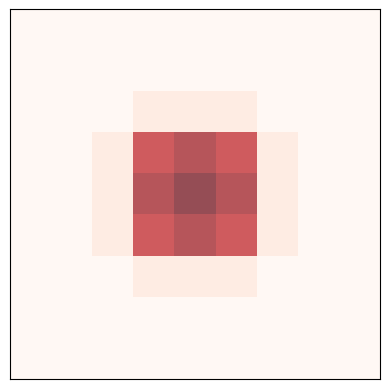

In [ ]:
diff.draw()

In [ ]:
diff.step()
diff.array

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.15, 0.17, 0.15, 0.02, 0.  , 0.  ],
       [0.  , 0.01, 0.15, 0.68, 0.81, 0.68, 0.15, 0.01, 0.  ],
       [0.  , 0.01, 0.17, 0.81, 0.96, 0.81, 0.17, 0.01, 0.  ],
       [0.  , 0.01, 0.15, 0.68, 0.81, 0.68, 0.15, 0.01, 0.  ],
       [0.  , 0.  , 0.02, 0.15, 0.17, 0.15, 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

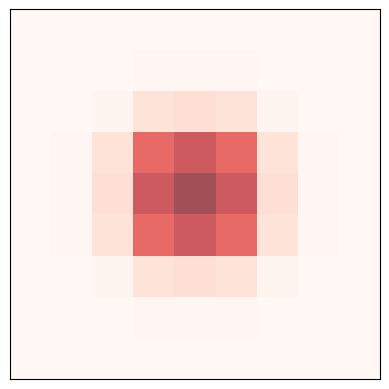

In [ ]:
diff.draw()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.

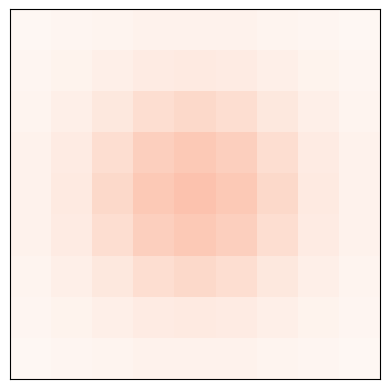

In [ ]:
diff.animate(frames=20, interval=0.1)

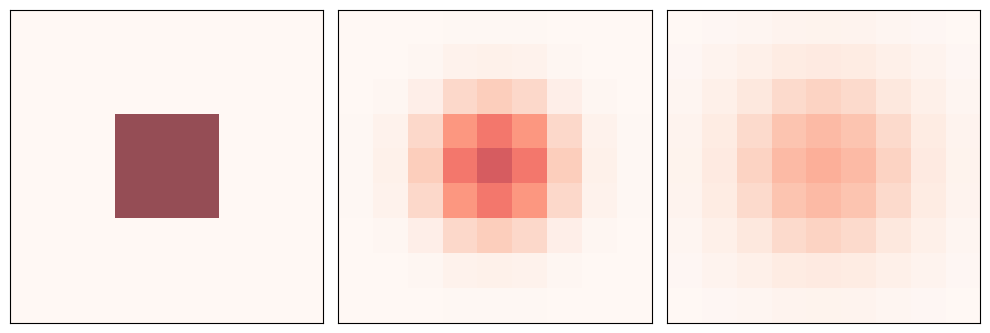

In [ ]:
from utils import three_frame

diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
three_frame(diff, [0, 5, 10])


## Reaction-Diffusion

Now we'll add a second material and let them interact.

The following function helps with setting up the initial conditions.

In [ ]:
def add_island(a, height=0.1):
    """Adds an island in the middle of the array.

    height: height of the island
    """
    n, m = a.shape
    radius = min(n, m) // 20
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] += height

For the recation-diffusion model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

In [ ]:
class ReactionDiffusion(Diffusion):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, params, noise=0.1):
        """Initializes the attributes.

        n: number of rows
        params: tuple of (Da, Db, f, k)
        Da: The diffusion rate of chemical A
        Db: The diffusion rate of chemical B
        f: The feed rate, which controls how quickly A is added to the system
        k: The kill rate, which controls how quickly B is removed from the system
        """
        self.params = params
        self.array1 = np.ones((n, n), dtype=float) # chemical A
        self.array2 = noise * np.random.random((n, n)) # chemical B
        add_island(self.array2) # add an island of higher concentration in the middle of chemical B

    def step(self):
        """Executes one time step."""
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params

        options = dict(mode='same', boundary='wrap')

        # slide kernel over array: element-wise multiplication and then sum up
        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)

        # represents the rate that A and B react with each other.
        # speciafically, the chance that one A and two B will come together
        reaction = A * B**2  # same as A * B * B

        # update states:
        # ra and rb are diffusion rate of chemical A and B respectively;
        # f is the “feed” rate, which controls how quickly A is added to the system;
        # k is the “kill” rate, which controls how quickly B is removed from the system;

        # Assuming that the reaction consumes A and produces B, we subtract reaction rate from A and plus reaction rate to B;
        # in other words, A is converted to B, so subtract from A and added to B.

        # term f * (1-A) determines the rate that A is added to the system
        # term (f+k) * B determines the rate that B is removed from the system.

        # some ongoing balance will be achieved while consuming A but also adding A back to system.
        # Eventually, as long as the rate parameters are not too high, the values of A and B usually stay between 0 and 1.
        self.array1 += ra * cA - reaction + f * (1-A)
        self.array2 += rb * cB + reaction - (f+k) * B


    def loop100(self):
        self.loop(100)

    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic',
                       vmin=None, vmax=None)
        draw_array(self.array1, cmap='Reds', **options)
        draw_array(self.array2, cmap='Blues', **options)

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.

Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

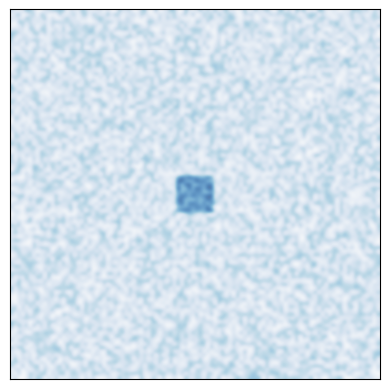

In [ ]:
params1 = 0.5, 0.25, 0.035, 0.057   # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(n=100, params=params3)
rd.draw()

In [ ]:
rd.array1

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
rd.array2

array([[0.06485014, 0.02999715, 0.02606893, ..., 0.01688401, 0.07005639,
        0.04693158],
       [0.01602492, 0.05777041, 0.09306984, ..., 0.04112677, 0.09575257,
        0.04058438],
       [0.04589771, 0.04641005, 0.04425303, ..., 0.05747487, 0.07664771,
        0.07059543],
       ...,
       [0.0099746 , 0.05461   , 0.06793349, ..., 0.02959926, 0.00613343,
        0.04119079],
       [0.04569301, 0.00232539, 0.06668582, ..., 0.0330455 , 0.01195805,
        0.00017513],
       [0.01891097, 0.054728  , 0.00718339, ..., 0.06139475, 0.02981929,
        0.02639518]])

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

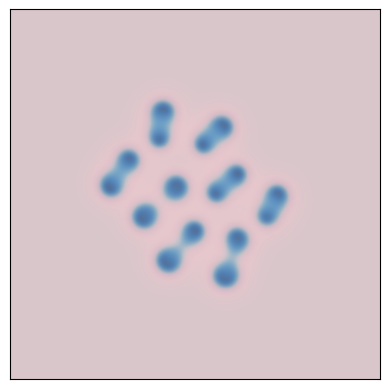

In [ ]:
rd.animate(frames=50, step=rd.loop100)

Use the following function to generate figures using different parameters.

In [ ]:
def make_rd(f, k, n=100):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params)
    return rd

The following parameters yield pink stripes and spots on a blue background:

Saving figure to file figs/rd1


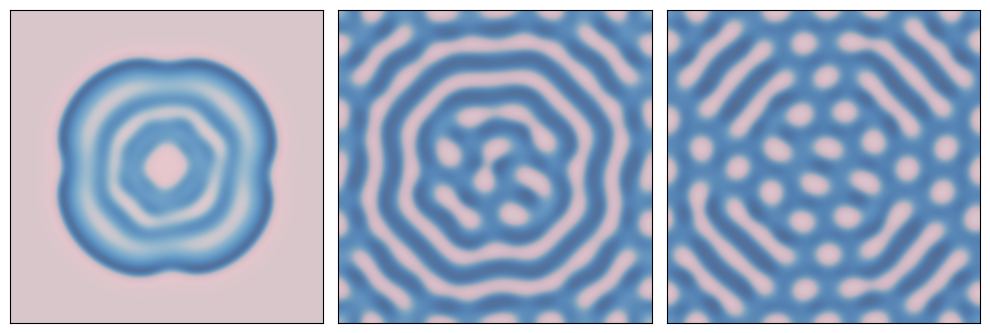

In [ ]:
from utils import three_frame

def plot_rd(f, k, filename):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(100, params)

    three_frame(rd, [1000, 2000, 4000]) # diffusion after 1000, 2000 and 4000 steps

    savefig(filename)

plot_rd(0.035, 0.057, 'figs/rd1')

The following parameters yield blue stripes on a pink background.

Saving figure to file figs/rd2


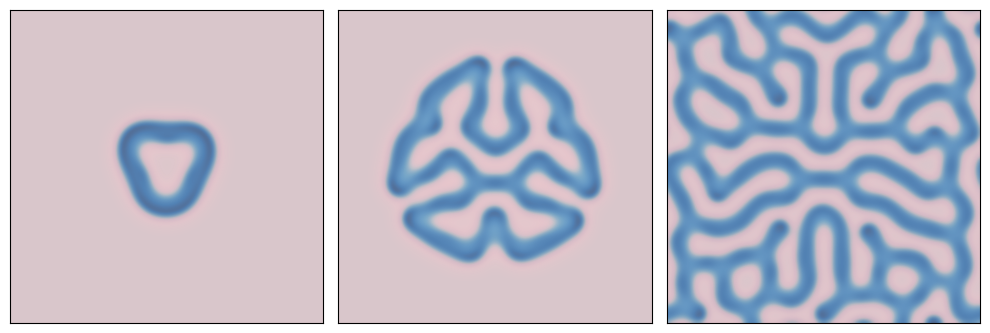

In [ ]:
plot_rd(0.055, 0.062, 'figs/rd2')

The following parameters yield blue dots on a pink background

Saving figure to file figs/rd3


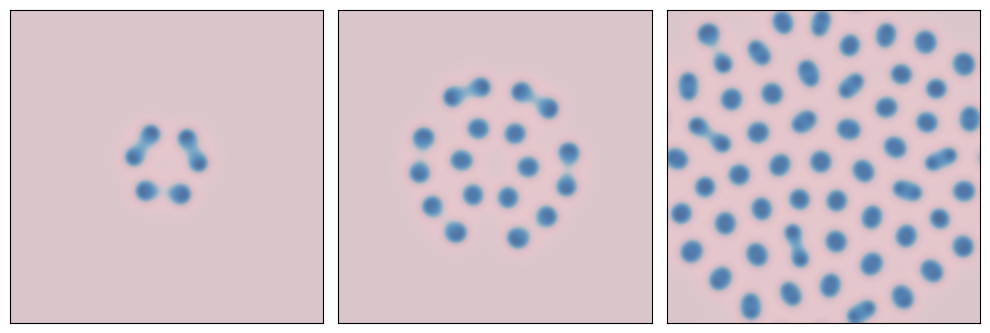

In [ ]:
plot_rd(0.039, 0.065, 'figs/rd3')